In [14]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
import fit_library as fit
%matplotlib nbagg

%load_ext autoreload
%autoreload 2
import system_of_units as units
import time
import FEE_vhb as FEE
import tables
#import mplFunctions as mpl
#import wfmFunctions as wfm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Definitions and Data

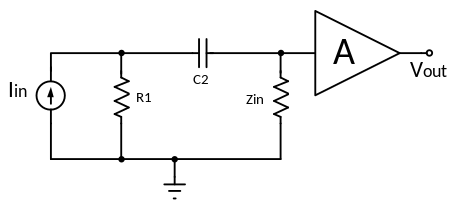

In [15]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_simple.png")

In [16]:
DAQ_GAIN=1.25
MEASURED_GAIN = 582.237
NOISE_LSB = 0.75

sfe = FEE.SimpleFee(gain=MEASURED_GAIN*units.ohm, C2=8*units.nF, 
                    R1=1567*units.ohm, Zin=62*units.ohm, 
                    f_sample=1./(25*units.ns), f_LPF1=3E6*units.hertz, 
                    f_LPF2=10E6*units.hertz,
                    noise_FEEPMB_rms=0.20*units.mV)
sfe
#                    noise_daq_rms=0.31*units.mV, 


        (C2 =     8.0 nf, R1 =  1567.0 ohm, Zin =    62.0 ohm,
         gain =   582.2 ohm, f_sample =    40.0 MH,
         self.freq_HPF =   12.21 kHz, self.freq_LPF1 =    3.00 MHZ,
         self.freq_LPF2 =   10.00 MHZ,
         self.freq_HPFd =  0.00061  self.freq_LPF1d =    0.15
         self.freq_LPF2d =    0.50,
         self.noise_FEEPMB_rms =    0.20 mV,
         self.LSB =    0.00 mV)
        

In [17]:
#R1 = 1567
#C2 = 8E-9
#Zin = 62
#f_sample = 40E6
#freq_HPF=1/((R1+Zin)*C2); print 'HPF1(kHz) =',freq_HPF/(1E3*2*np.pi)
#freq_LPF1=3E6*2*np.pi; print 'LPF1(MHz) =',freq_LPF1/(1E6*2*np.pi)
#freq_LPF2=10E6*2*np.pi; print 'LPF2(MHz) =',freq_LPF2/(1E6*2*np.pi)
#freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
#freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
#freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d

f_sample = sfe.f_sample/units.hertz; print "f_sample (Hz)= ", f_sample
R1=sfe.R1/units.ohm; print "R1= ", sfe.R1/units.ohm
Zin=62; 
C2=sfe.C2/units.farad; print "C2= ",sfe.C2/units.nF


A1=R1*Zin/(R1+Zin)
A2=(MEASURED_GAIN/A1)*1.003991; print "A1= ",A1, "A2= ",A2, "MEASURED_GAIN= ",MEASURED_GAIN
#Butterworth Design Gain Factor
GAIN=A1*A2 
# Seems stupid. It's just to remember true GAIN measured in simulation 

LSB_DAQ=(2.0/4096); print "LSB_DAQ (V)= ",LSB_DAQ
LSB_FEE=LSB_DAQ/DAQ_GAIN; print "LSB_FEE (V)= ",LSB_FEE
# Remember the ADC GAIN FACTOR = 1.25
SPE = 20; print "SPE (iLSB_ADC)= ", SPE
# Calibrated SPE value in LSB



f_sample (Hz)=  40000000.0
R1=  1567.0
C2=  8.0
A1=  59.6402701044 A2=  9.8014429989 MEASURED_GAIN=  582.237
LSB_DAQ (V)=  0.00048828125
LSB_FEE (V)=  0.000390625
SPE (iLSB_ADC)=  20


# ======  FEE MODEL ======

In [18]:
#b0, a0 = signal.butter(1, freq_HPFd, 'high', analog=False)
#b1, a1 = signal.butter(1, freq_LPF1d, 'low', analog=False); b2, a2 = signal.butter(4, freq_LPF2d, 'low', analog=False);
#a_LPF=np.convolve(a1,a2,mode='full'); a=np.convolve(a_LPF,a0,mode='full')
#b_LPF=np.convolve(b1,b2,mode='full'); b_aux2=np.convolve(b_LPF,b0,mode='full'); b=GAIN*b_aux2

b,a = FEE.filter_fee(sfe); b = b/units.ohm

<IPython.core.display.Javascript object>


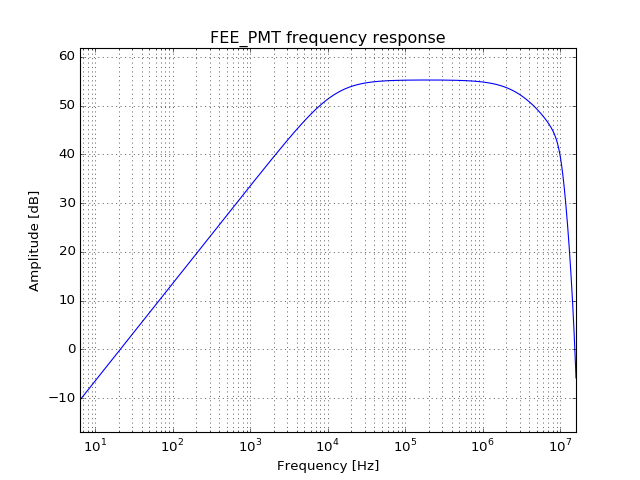

In [19]:
w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
plt.figure(2)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
#plt.axvline(freq_HPFd, color='green') # cutoff frequency
plt.show()

# ====== TEST ADDING NOISE  ======

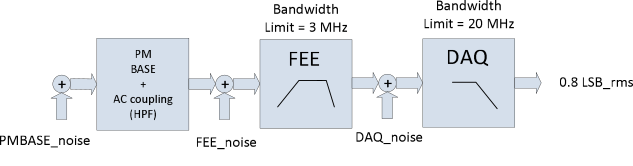

In [20]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "NOISE.png")

$$ GAIN=FEE_{GAIN}.DAQ_{GAIN} $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = v_{DAQnoise}^{2}(out) + v_{FEE+PMBnoise}^{2}(out) $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = \int_{0}^{BW=3MHz}{v_{FEE+PMBnoise}^{2}.{\lvert}GAIN.H(jw){\rvert}^2}  + \int_{0}^{BW=20MHz}{v_{DAQnoise}^{2}.{\lvert}DAQ_{GAIN}.H(jw){\rvert}^2} $$
$$ $$
$$ vo_{TOTAL_{noise(rms)}} = \sqrt{vo_{TOTAL_{noise}}^{2}} = 0.76LSB_{rms}$$

## MEASURED NOISE 
$$ v_{DAQnoise}^{2}(out) = 0.64 LSB_{rms} = 0.3136 mV_{rms} $$
$$ v_{FEE+PMBnoise}^{2}(out) = 0.41 LSB_{rms} = 0.2009 mV_{rms} $$

## Since we need the equivalent input noise in order to filter it and study the passband effect we should compute the integral of the frequency response of the FEE (this is quite hard). Instead of doing this we "find" a value for the std of the equivalent input noise which produces an output noise contribution of the same order as the measured one.

In [21]:
signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*1E-3

noise_FEEin = np.random.normal(0,1*LSB_DAQ/(GAIN*DAQ_GAIN),31000)
# Equivalent Noise of the FEE + PMT BASE added at the input of the system to get the noise filtering effect
noise_DAQout = np.random.normal(0,0.64*LSB_DAQ,31000)
# Equivalent Noise of the DAQ added at the output of the system

signal_out1 = FEE.signal_fee(sfe,signal_in+noise_FEEin)*GAIN*DAQ_GAIN+noise_DAQout


print "TRUE Out Noise (LSB_rms) =",np.std(signal_out1[25000:26000],ddof=1)/LSB_DAQ

TRUE Out Noise (LSB_rms) = 0.810445401946


<IPython.core.display.Javascript object>


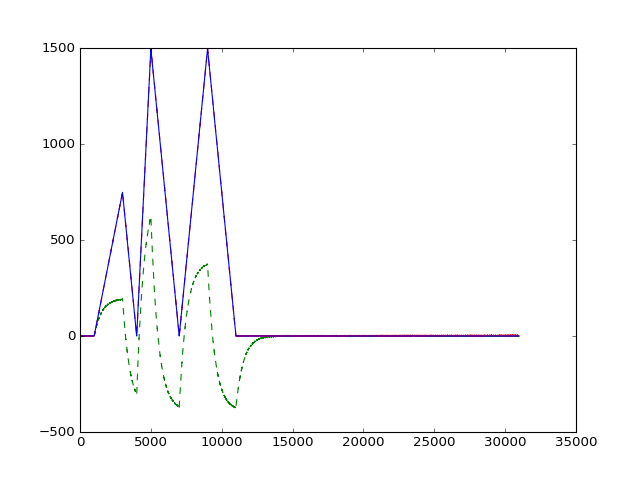

In [22]:
coef_BLR = sfe.freq_HPFd*np.pi
recons1 = BLRc(signal_daq=signal_out1,coef=coef_BLR,thr = 0.5*LSB_DAQ)
# BLR reconstruction with pure algorithm

plt.figure(1)
plt.plot(range(0,np.size(signal_out1),1),signal_out1/LSB_DAQ,'g--')
plt.plot(range(0,np.size(recons1),1),recons1/LSB_DAQ,'r--')
plt.plot(range(0,np.size(signal_in),1),GAIN*DAQ_GAIN*signal_in/LSB_DAQ)
plt.show()

In [23]:
input_e = np.sum(GAIN*DAQ_GAIN*signal_in/LSB_DAQ)/SPE
recons_e = np.sum(recons1[1000:11000]/LSB_DAQ)/SPE
print 'Input (SPE) =', input_e
print 'Reconstructed (SPE) =', recons_e
print 'Error in SPE Computation (%) = ', (input_e-recons_e)/input_e*100

print 'Tail Noise (LSB) =', np.std(recons1[25000:26000],ddof=1)/LSB_DAQ
print 'Tail Mean (LSB)=', np.mean(recons1[25000:26000])/LSB_DAQ


Input (SPE) = 318001.02508
Reconstructed (SPE) = 318208.166647
Error in SPE Computation (%) =  -0.0651386478377
Tail Noise (LSB) = 0.812006603329
Tail Mean (LSB)= 1.98938866662


## Tail Noise is coherent with expected value. Tail Mean is random and is related to the practical non-zero mean of the noise along the signal length

## ==================================================

## ==================================================

# EFFECT OF NOISE IN AC COUPLED FEE
## Noise is added after the AC filter as an equivalent input noise (FEE) which produces the lab measured noise at the output

In [24]:
recons_a = np.zeros(2000)
for i in range(0,2000):
    noise_FEEin = np.random.normal(0,1*LSB_DAQ/(GAIN*DAQ_GAIN),31000)
    noise_DAQout = np.random.normal(0,0.64*LSB_DAQ,31000)
    signal_out1_b = FEE.signal_fee(sfe,signal_in+noise_FEEin)*GAIN*DAQ_GAIN+noise_DAQout
    recons1 = BLRc(signal_daq=signal_out1_b,coef=coef_BLR,thr = 0.75*LSB_DAQ)  
    recons_a[i] = np.sum(recons1[1000:11000])


<IPython.core.display.Javascript object>


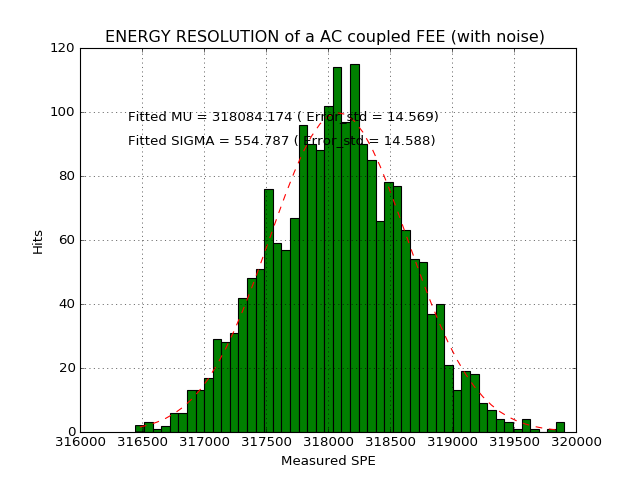

('Fitted A = ', 99.805163136579765, '( Error_std=', 2.2703630519599018, ')')
('Fitted MU = ', 318084.17436139961, '( Error_std=', 14.56913399160767, ')')
('FItted SIGMA = ', 554.78694784259199, '( Error_std=', 14.588341489204195, ')')
ENERGY RESOLUTION (%) =  0.409875571473


In [25]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,6,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

# ==================================================

# EFFECT OF NOISE IN DC COUPLED FEE

recons_b = np.zeros(1000)
for i in range(0,1000):
    noise_FEEin = np.random.normal(0,1*LSB_DAQ/(GAIN*DAQ_GAIN),31000)
    noise_DAQout = np.random.normal(0,0.64*LSB_DAQ,31000)
    signal_out1_b = FEE.signal_fee_lpf(sfe,signal_in+noise_FEEin)*GAIN*DAQ_GAIN+noise_DAQout
    #print 'Tail Noise =', np.std(recons1b[25000:26000],ddof=1)/LSB
    recons_b[i] = np.sum(signal_out1_b[1000:11000])
  


[coef2,error2]=fit.gauss1_fit(recons_b/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a DC coupled FEE (with noise) ',50,7,1)
print "ENERGY RESOLUTION (%) = ",(coef2[2]/coef2[1])*100*2.35